In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Read manufacturing data
# https://www.kaggle.com/datasets/supergus/multistage-continuousflow-manufacturing-process
df = pd.read_csv("", sep=";")
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.strftime('%d/%m/%Y %H:%M:%S')
df.index = df["time"]
df = df.drop("time",axis=1)
df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
df = df['cpk']
df.head()

# MULTI
# # Types of columns
# df1.head()

# # reduce correlated variables
# cor_matrix = df1.corr().abs()
# upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
# df2 = df1.drop(to_drop, axis=1)
# df2 = pd.DataFrame(df2)
# df2.head()

# # conduct PCA
# std = StandardScaler()
# transformed = pd.DataFrame(StandardScaler().fit_transform(df2))
# transformed.index = df["time"]
# df3 = transformed.iloc[:, 0:16]
# df3.columns = ['pca_comp_%i' % i for i in range(16)] 
# df = df3


time
03/06/2019 10:54:00    0.414425
03/06/2019 10:55:00    0.414578
03/06/2019 10:56:00    0.431932
03/06/2019 10:57:00    0.450607
03/06/2019 10:58:00    0.470852
Name: cpk, dtype: float64

In [16]:
train_size = int(len(df) * 0.8)
train_df = np.array(df.iloc[:train_size])
train_df = train_df.reshape(-1, 1)

val_df = np.array(df.iloc[train_size:])
val_df = val_df.reshape(-1, 1)



In [17]:
scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)



In [73]:
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def transformer_model(seq_length, num_features, d_model, n_heads, dense_units, dropout_rate, n_layers):
    input_layer = Input(shape=(seq_length, num_features))

    # Multi-Head Self-Attention layer
    multi_head_attention = input_layer
    for i in range(n_layers):
        multi_head_attention = MultiHeadAttention(num_heads=n_heads, key_dim=d_model)(multi_head_attention, multi_head_attention)
        multi_head_attention = Dropout(dropout_rate)(multi_head_attention)
        multi_head_attention = LayerNormalization(epsilon=1e-6)(multi_head_attention)
        multi_head_attention = multi_head_attention + input_layer

    # Position-wise Feedforward layer
    position_wise_ff = multi_head_attention
    for i in range(n_layers):
        position_wise_ff = Dense(units=dense_units, activation='relu')(position_wise_ff)
        position_wise_ff = Dropout(dropout_rate)(position_wise_ff)
        position_wise_ff = LayerNormalization(epsilon=1e-6)(position_wise_ff)
        position_wise_ff = position_wise_ff + multi_head_attention

    # Output layer
    output_layer = Dense(units=num_features)(position_wise_ff)

    model = Model(inputs=[input_layer], outputs=[output_layer])
    return model

# Define window size
WINDOW_SIZE = 10

# Convert data to sliding windows
def to_sliding_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        windows.append(data[i:i+window_size])
    return np.array(windows)

# Convert train and validation data to sliding windows
train_x = to_sliding_windows(train_df, WINDOW_SIZE)
train_y = train_x[:, -1]
train_x = train_x[:, :-1]
val_x = to_sliding_windows(val_df, WINDOW_SIZE)
val_y = val_x[:, -1]
val_x = val_x[:, :-1]

SEQ_LENGTH = WINDOW_SIZE - 1  # the input sequence length is the window size minus one
NUM_FEATURES = 1
D_MODEL = 64
N_HEADS = 8
DENSE_UNITS = 128
DROPOUT_RATE = 0.2
N_LAYERS = 4

model = transformer_model(SEQ_LENGTH, NUM_FEATURES, D_MODEL, N_HEADS, DENSE_UNITS, DROPOUT_RATE, N_LAYERS)

model.compile(loss=MeanSquaredError(), optimizer=Adam(lr=0.001))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(val_x, val_y), callbacks=[early_stop])


Epoch 1/100
345/345 [==============================] - 20s 39ms/step - loss: 0.2128 - val_loss: 0.0157
Epoch 2/100
345/345 [==============================] - 13s 37ms/step - loss: 0.0287 - val_loss: 0.0130
Epoch 3/100
345/345 [==============================] - 13s 37ms/step - loss: 0.0231 - val_loss: 0.0128
Epoch 4/100
345/345 [==============================] - 13s 37ms/step - loss: 0.0217 - val_loss: 0.0128
Epoch 5/100
345/345 [==============================] - 13s 37ms/step - loss: 0.0212 - val_loss: 0.0130
Epoch 6/100
345/345 [==============================] - 13s 37ms/step - loss: 0.0213 - val_loss: 0.0125
Epoch 7/100
345/345 [==============================] - 13s 38ms/step - loss: 0.0208 - val_loss: 0.0125
Epoch 8/100
345/345 [==============================] - 13s 39ms/step - loss: 0.0209 - val_loss: 0.0126
Epoch 9/100
345/345 [==============================] - 13s 39ms/step - loss: 0.0210 - val_loss: 0.0132
Epoch 10/100
345/345 [==============================] - 13s 38ms/step - l

In [74]:
y_pred = model.predict(val_x)
y_pred_last = y_pred[:, -1, :]
mse = np.mean((y_pred_last - val_y)**2)
print('Mean squared error:', mse)

86/86 [==============================] - 1s 14ms/step
Mean squared error: 0.0011326406391499132


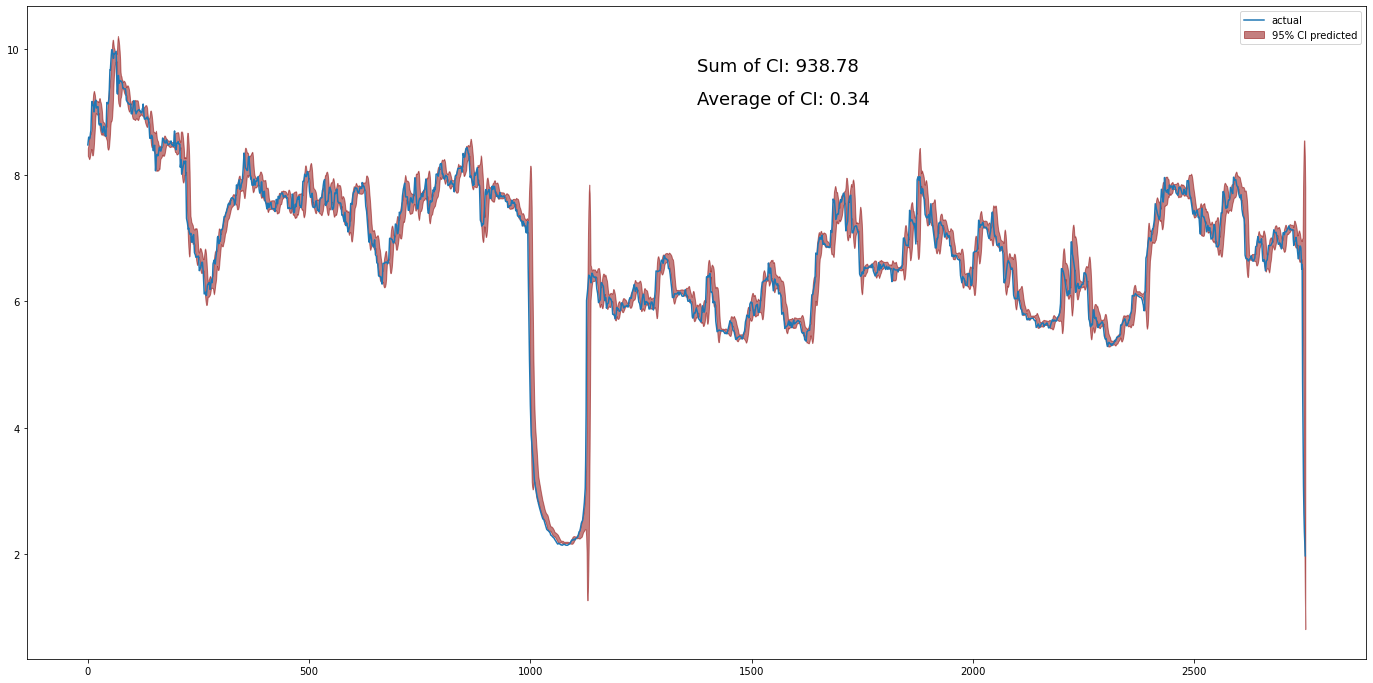

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Rescale the standardized predictions to their original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
y_val_rescaled = scaler.inverse_transform(val_y.reshape(-1, 1)).reshape(val_y.shape)

# Take the average and standard deviaton of all predictions for each time step
y_pred_mean = np.mean(y_pred_rescaled, axis=1)
y_pred_std = np.std(y_pred_rescaled, axis=1)

# Calculate the upper and lower bounds of the 95% confidence interval
upper_bound = y_pred_mean + 1.96 * y_pred_std
lower_bound = y_pred_mean - 1.96 * y_pred_std

# Reshape the lower_bound and upper_bound arrays to be 1-dimensional
lower_bound = lower_bound.reshape(-1)
upper_bound = upper_bound.reshape(-1)

# Calculate the sum of the confidence interval over all time steps
ci_sum = np.sum(upper_bound - lower_bound)
ci_avg = np.mean(upper_bound - lower_bound)

# Create figure and set size
plt.figure(figsize=(24, 12))

# Plot actual vs predicted
plt.plot(y_val_rescaled, label='actual')
# plt.plot(y_pred_mean, label='predicted')
plt.fill_between(range(len(val_y)), lower_bound, upper_bound, alpha=0.5, color='darkred', label='95% CI predicted')
plt.legend()

# Add CI sum to the plot
plt.text(0.5, 0.9, f'Sum of CI: {ci_sum:.2f}', transform=plt.gca().transAxes, fontsize=18)
plt.text(0.5, 0.85, f'Average of CI: {ci_avg:.2f}', transform=plt.gca().transAxes, fontsize=18)


plt.show()



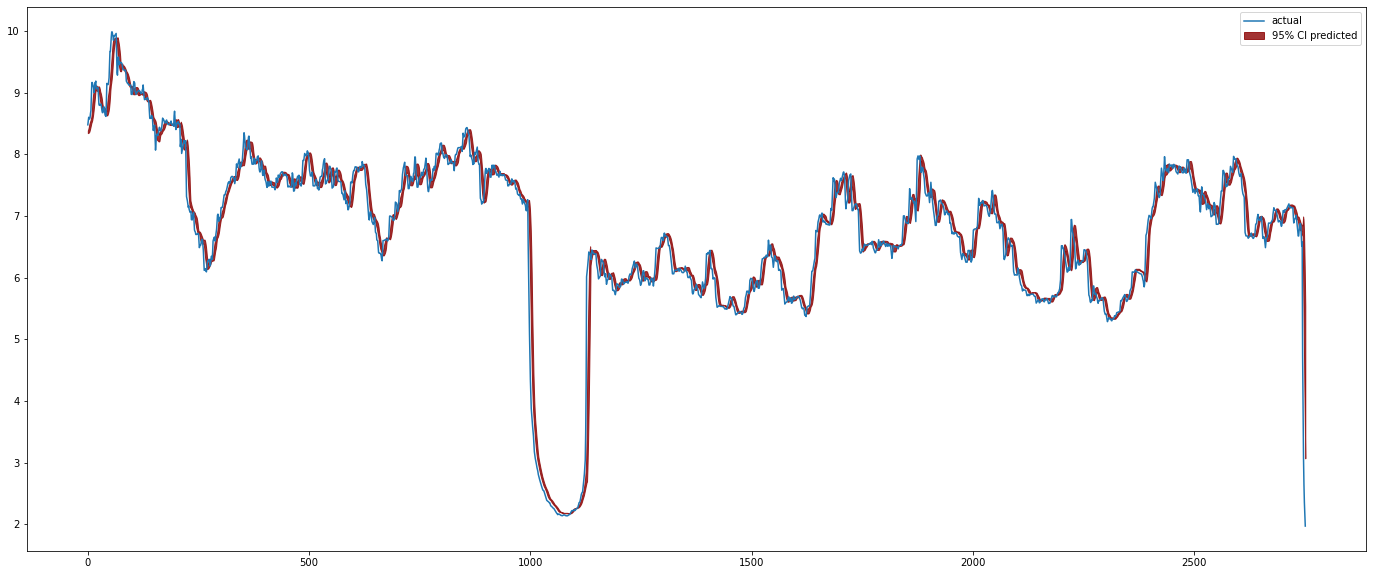

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Rescale the standardized predictions to their original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

# Take the average of all predictions for each time step
y_pred_mean = np.mean(y_pred_rescaled, axis=1)

# Calculate the upper and lower bounds of the confidence interval
confidence = 0.95
n = y_pred_rescaled.shape[0]
m = y_pred_rescaled.shape[1]
std_err = stats.sem(y_pred_rescaled, axis=1)
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
lower_bound = y_pred_mean - h
upper_bound = y_pred_mean + h

# Reshape the lower_bound and upper_bound arrays to be 1-dimensional
lower_bound = lower_bound.reshape(-1)
upper_bound = upper_bound.reshape(-1)

# Plot actual vs predicted with confidence interval
fig = plt.figure(figsize=(24, 10))
plt.plot(scaler.inverse_transform(val_y.reshape(-1, 1)), label='actual')
# plt.plot(y_pred_mean, label='predicted')
plt.fill_between(range(len(val_y)), lower_bound, upper_bound, alpha=0.8, color='darkred', label='95% CI predicted')
plt.legend()
plt.show()
